# Windy-cliff-walking with direct optimization

### As a first step, we define a map in which an optimal trajectory is a 4 steps solution. The policy network's output is a 4 steps  trajectory, and then the network is updated by direct optimization which searches across all of the combinations of 4 steps (4^4). 


In [1]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import numpy as np
import pandas as pd
import itertools
from matplotlib.colors import hsv_to_rgb


In [2]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [3]:
steps = 4
height = 2*steps+1
width = 2*steps+1
start = (steps,steps)
obj = (steps,steps+2)



In [4]:
class GridWorld:
    terrain_color = dict(normal=[127.0/360, 0.0, 96.0/100],
                         objective=[26.0/360, 100.0/100, 100.0/100],
                         cliff=[247.0/360, 92.0/100, 70.0/100],
                         player=[344.0/360, 93.0/100, 100.0/100])
    
        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((height, width, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid,history = None):
        grid[start[0], start[1]:obj[1]] = self.terrain_color['cliff']
        grid[obj] = self.terrain_color['objective']
        grid[start] = self.terrain_color['player']
        if history is not None:
            for idx in history:
                grid[self._id_to_position(idx)] = self.terrain_color['player']
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.ax.grid(which='minor')
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], s='0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(height * width)]  
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(width))
        self.ax.set_xticks(np.arange(width) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(height))
        self.ax.set_yticks(np.arange(height) - 0.5, minor=True)
        
    def reset(self):
        self.player = start      
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions        
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < height - 1:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < width - 1:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        self._add_wind(self.player[1])            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _add_wind(self,x_loc):
        
        #wind_row = [0.4,0]
        #y_loc = 0 if self.player[0]%2 ==0 and self.player[1]%2 ==0 else 1
        p = np.random.random()
        if p<wind[x_loc] and self.player[0] < height-1:
            self.player = (self.player[0]+1, self.player[1])
            
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * width + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // width), (idx % width)
        
    def render(self, q_values=None, action=None,history = None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((height, width, 3))
            values = change_range(np.max(q_values, -1)).reshape(height, width)
            grid[:, :, 1] = values
            self._add_objectives(grid,history)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(width), height)
            ys = np.tile(np.arange(height), width)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        #if action is not None:
            #self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        #plt.pause(0.01)

In [5]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
ACTIONS = ['UP', 'DOWN', 'RIGHT', 'LEFT']

wind = [0 for _ in range(width)] # probability of being pushed down at column i
wind[5] = 0.1


In [6]:
wind

[0, 0, 0, 0, 0, 0.1, 0, 0, 0]

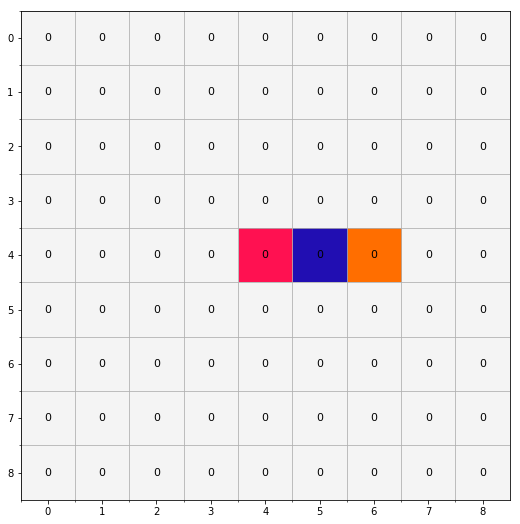

In [7]:
env = GridWorld()

We need a table of values that maps each state-action pair to a value, we'll create such table and initialize all values to zero (or to a random value)

In [8]:
# The number of states in simply the number of "squares" in our grid world, in this case 4 * 12
num_states = width * height
# We have 4 possible actions, up, down, right and left
num_actions = 4
traj_space = list(itertools.product(range(num_actions),repeat = steps)) #num_actions ** steps
traj_to_idx = {t : i for i,t in enumerate(traj_space)}


## Policy Gradient with Gumbels

Note that the policy network doesn't get any variable as input

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [10]:
class TrajectoryPolicy(nn.Module):
    def __init__(self):
        super(TrajectoryPolicy, self).__init__()       
        
        self.fc = nn.Linear(40,len(traj_space))
        
    def forward(self):
        const = torch.ones(1,40)
        scores = self.fc(const)
        z_phi_gamma,phi_x_gamma = self.gumbel_perturbation(scores)        
        actions = traj_space[z_phi_gamma]
        return actions,phi_x_gamma

    def sample_gumbel(self,shape, eps=1e-20):
        #Sample from Gumbel(0, 1)
        U = torch.rand(shape).float()
        return -torch.log(eps - torch.log(U + eps))
    
    def gumbel_perturbation(self,phi_x, eps=1e-10):
        
        shape = phi_x.size()

        gumbel_noise = self.sample_gumbel(shape, eps=eps)
        phi_x_gamma = phi_x + gumbel_noise
        
        _, argmax = phi_x_gamma.data.max(-1)
        #z_phi_gamma = torch.FloatTensor(*shape).zero_().scatter_(-1, argmax, 1.0)        
        return argmax.item(),phi_x_gamma
    
policy = TrajectoryPolicy()
optimizer = optim.Adam(policy.parameters(), lr=0.001)

In [11]:
def run_episode(actions_list):
    rewards = []
    done = False
    success = False
    R = 0
    state = env.reset()
    for action in actions_list:
        
        if not done:
            state, reward, done = env.step(action)
        if reward==0:
            success = True
        #print env._id_to_position(state)
        rewards.append(reward)
        
    for r in rewards[::-1]:
        R = r + 0.99 * R   # gamma = 0.9
        rewards.insert(0, R)
    return sum(rewards),success

In [12]:
def compute_policy_gradients(hard,phi_x_g,epsilon=1.0):

    soft = phi_x_g.clone()
    hard = torch.LongTensor([hard]).unsqueeze(0)
    all_rewards = torch.zeros(len(traj_space))
    
    for i,actions in enumerate(traj_space):
        all_rewards[i],_ = run_episode(actions)
    all_rewards = epsilon*all_rewards
    soft = soft + all_rewards
    shape = soft.size()
    _, argmax = soft.max(-1)
    #print traj_space[argmax.item()]
    change = torch.FloatTensor(*shape).zero_().scatter_(-1, argmax.unsqueeze(0),1.0) # one-hot that points to the best direction
    hard = torch.FloatTensor(*shape).zero_().scatter_(-1, hard,1.0) 
    gradients = hard - change
    
    gradients = gradients*(1.0/epsilon)
    return gradients

In [13]:
run_episode((0,2,2,1)) # sanity check (the right path)

(-8.9601, True)

In [14]:
def policy_gradient(env, num_episodes=500,init_weights = True,train = True):
    global policy,optimizer

    if init_weights:
        policy = TrajectoryPolicy()
        optimizer = optim.Adam(policy.parameters(), lr=0.01)
    success = 0
    ep_rewards = []
    for i_episode in range(num_episodes):
        
        reward_sum = 0
        actions,phi_x_g = policy()
        reward_i,suc = run_episode(actions)
        gradients_direction = compute_policy_gradients(traj_to_idx[actions],phi_x_g)
        policy_loss = torch.sum(gradients_direction*phi_x_g)
        ep_rewards.append(reward_i)
        success += suc
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
    return ep_rewards,success

In [15]:
ep_rewards,success = policy_gradient(env,num_episodes=1000) #the policy gradient method needs much more episodes to converge
success

768

Mean Reward: -201.315160488


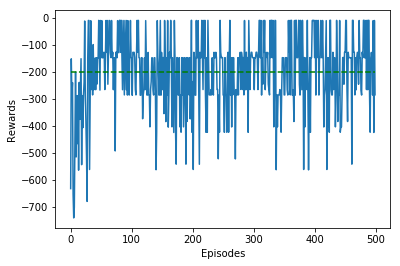

In [16]:
q_learning_pg_rewards, _ = zip(*[policy_gradient(env,500) for _ in range(10)])

avg_rewards = np.mean(q_learning_pg_rewards, axis=0)

mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))

In [17]:
actions,_=policy()
actions

(0, 2, 2, 1)

## Visualization

In [18]:
def play(actions):
    actions,_=policy()
    print [ACTIONS[actions[i]] for i in range(len(actions))]
    env = GridWorld()
    state = env.reset()
    done = False
    history = [state]
    for action in actions:    
        # Select action
        # Do the action
        next_state, reward, done = env.step(action)  
        history.append(next_state)
        # Update state and action        
        state = next_state  
        #raw_input("Press Enter to continue...")
        env.render(q_values= np.zeros((num_states, num_actions)),history=history, colorize_q=True)
        #raw_input("Press Enter to continue...")
        if done:
            return
    print 'path not found'

['UP', 'RIGHT', 'RIGHT', 'DOWN']


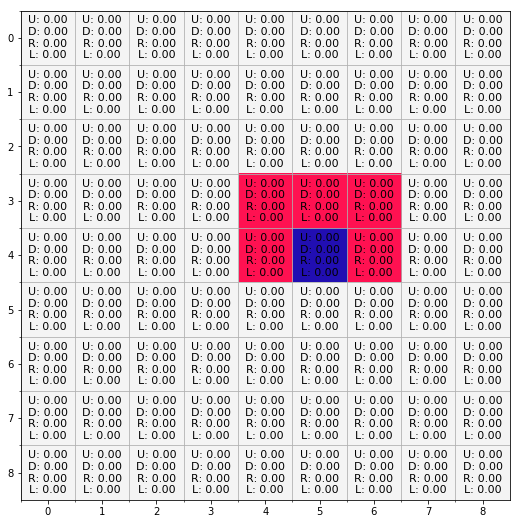

In [19]:
play(actions)